# Movie 5 - SWELL1 Distribution Upon Light Stimulation
## Load movie frames and perform segmentations

In [27]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import cv2

movie5_path = "movies/movie5.avi"

In [29]:
# Find contours and get the largest contour to represent the entire structure
# Get bounding rectangle of leftmost and rightmost sides
def get_bounding_boxes(img):
    contours, hierarchy = cv2.findContours(img, 1, 2)
    c = max(contours, key=cv2.contourArea)
    
    leftBoundingRect = cv2.boundingRect(c[c[:, :, 0].argmin()])
    rightBoundingRect = cv2.boundingRect(c[c[:, :, 0].argmax()])

    return leftBoundingRect, rightBoundingRect, c

def check_sections(frame, check_size=10, min_mean_pixel=0.03):
    sections = []
    for c in range(0, frame.shape[1], check_size):
        mean_pixel = cv2.mean(frame[:,c:c+check_size])[0]
        #print("Current mean pixel:", mean_pixel)
        sections.append((mean_pixel, c, check_size))
    return sections

def get_left_side(frame, check_size=10, min_mean_pixel=0.03):
    for c in range(0, frame.shape[1], check_size):
        mean_pixel = cv2.mean(frame[:,c:c+check_size])[0]
        if mean_pixel > min_mean_pixel:
            return c
    return 0

def get_right_side(frame, check_size=10, min_mean_pixel=0.03):
    for c in range(frame.shape[1], 0, -(check_size)):
        mean_pixel = cv2.mean(frame[:,c-check_size:c])[0]
        if mean_pixel > min_mean_pixel:
            return c
    return 0

## Calibrate and estimate parameters for segments

### Algorithm to find left and right edges
- Break the grayed frame into a contibuous sequence of rectangles of width 'check_size'.
- Calculate mean pixel values of each rectangle
- Return the first rectangle whose mean pixel value exceeds the threshold value 'min_mean_pixel'

### Applying the algorithm
- The appropriate width of each edge is set to 40 for this movie.
- Some correction values may also be used to include all pixels at edges

In [32]:
print("Press 'q' to end video")
cap = cv2.VideoCapture(movie5_path)

# Get movie frame size
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH) + 0.5)
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT) + 0.5)
frame_size = (width,height)

frame_index = 0 # Track frame number for fluorescent intensity table

while True:
    success, frame = cap.read()

    if success and frame.size != 0:
        # Crop frame to remove text
        canvas = np.ones((frame.shape), np.uint8)
        canvas[35:90, :] = frame[35:90, :]
        isolated_cell = frame[35:90, :]
        canvas = cv2.cvtColor(canvas, cv2.COLOR_BGR2RGB)
        
        # Blur to fill threshold gaps
        gray_frame = cv2.cvtColor(canvas, cv2.COLOR_BGR2GRAY)
        _, imgThreshold = cv2.threshold(gray_frame, 20, 255, cv2.THRESH_BINARY)
        blur_frame = cv2.GaussianBlur(imgThreshold, (7, 7), 0)

        edge_width = 10

        sections = check_sections(blur_frame, check_size=edge_width)
        for mean_pixel, position, width in sections:
            #print("Mean pixels:", mean_pixel)
            cv2.rectangle(canvas, (position,0), (position+width,canvas.shape[0]), (255, 255, 0), 1)
        
        left_side = get_left_side(blur_frame, check_size=edge_width, min_mean_pixel=9)
        right_side = get_right_side(blur_frame, check_size=edge_width, min_mean_pixel=9)
        
        left_side_thickness = 40
        right_side_thickness = 40
        left_side_offset_correction = 10
        right_side_offset_correction = 10

        # Left edge
        cv2.rectangle(canvas, (left_side-left_side_offset_correction,35), 
                              (left_side+left_side_thickness+left_side_offset_correction, 90), 
                              (255, 255, 255), 1)

        # Right edge
        cv2.rectangle(canvas, (right_side-right_side_thickness,35), 
                              (right_side, 90), 
                              (255, 255, 0), 1)

        # Entire cell
        cv2.rectangle(canvas, (left_side-left_side_offset_correction,35),
                              (right_side, 90), 
                              (0, 255, 255), 1)

        cv2.imshow("Movie 5", canvas)


    # 1 frame per second
    if cv2.waitKey(500) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

Press 'q' to end video


## Mean pixels at edge as fluorescent intensity values
- The mean pixel values obtained with 'cv2.mean()' are used as fluorescent intensity values
- Each value in each frame is appended to the 'fluorescent_intensities' list which will be converted to a Pandas dataframe for analysis
- The position of the trailing edge (left side) is also included to represent the position of the cell in each frame.
- The relative change in position will be used as displacement and for calculating velocity
- The time interval between each frame is 10 minutes.

In [35]:
print("Press 'q' to stop video")
cap = cv2.VideoCapture(movie5_path)

# Get movie frame size
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH) + 0.5)
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT) + 0.5)
frame_size = (width,height)

# Initialize video writer to save segmented movie at 1 frame per second
writer = cv2.VideoWriter("output5.avi", cv2.VideoWriter_fourcc(*"XVID"), 1.0, frame_size)

frame_index = 0 # Track frame number for fluorescent intensity table

fluorescent_intensities = []

while True:
    frame_index += 1
    success, frame = cap.read()

    if success and frame.size != 0:
        # Crop frame to remove text
        canvas = np.ones((frame.shape), np.uint8)
        canvas[35:90, :] = frame[35:90, :]
        
        # Blur to fill threshold gaps
        gray_frame = cv2.cvtColor(canvas, cv2.COLOR_BGR2GRAY)
        _, imgThreshold = cv2.threshold(gray_frame, 20, 255, cv2.THRESH_BINARY)
        blur_frame = cv2.GaussianBlur(imgThreshold, (7, 7), 0)

        edge_width = 10

        # Get trailing and leading bounding rectangle, and entire cell contour
        left_side = get_left_side(blur_frame, check_size=edge_width, min_mean_pixel=9)
        right_side = get_right_side(blur_frame, check_size=edge_width, min_mean_pixel=9)

        left_side_thickness = 40
        right_side_thickness = 40
        left_side_offset_correction = 10
        # right_side_offset_correction = 10

        # Left edge
        cv2.rectangle(canvas, (left_side-left_side_offset_correction,35), 
                              (left_side+left_side_thickness+left_side_offset_correction, 90), 
                              (255, 255, 255), 1)

        # Right edge
        cv2.rectangle(canvas, (right_side-right_side_thickness,35), 
                              (right_side, 90), 
                              (255, 255, 0), 1)

        # Entire cell
        cv2.rectangle(canvas, (left_side-left_side_offset_correction,35),
                              (right_side, 90), 
                              (0, 255, 255), 1)

        
        # Calculate mean intensity at trailing edge
        trailing_edge = gray_frame[35:90, left_side-left_side_offset_correction:left_side+left_side_thickness+left_side_offset_correction]
        trailing_edge_intensity = cv2.mean(trailing_edge)
        #print("Trailing Edge:", trailing_edge_intensity)

        # Calculate mean intensity at leading edge
        leading_edge = gray_frame[35:90, right_side-right_side_thickness:right_side]
        leading_edge_intensity = cv2.mean(leading_edge)
        #print("Leading Edge:", leading_edge_intensity)

        # Append intensity data to list
        fluorescent_intensities.append([frame_index, trailing_edge_intensity[0], leading_edge_intensity[0], (frame_index*10)-10, left_side])

        writer.write(canvas)

        cv2.imshow("Movie 5: Light Stimulated SWELL1", canvas)

    else:
        break

    # 1 frame per second
    if cv2.waitKey(100) & 0xFF == ord('q'):
        break

cap.release()
writer.release()
cv2.destroyAllWindows()

Press 'q' to stop video


## Calculate Displacements and Velocities

In [38]:
intensity_dataframe = pd.DataFrame(fluorescent_intensities, columns =  ["Frame", "Trailing", "Leading", "Time", "Position"])
# Displacement = All Positions - Starting position
intensity_dataframe["Displacement"] = intensity_dataframe["Position"] - intensity_dataframe["Position"][0]
# Time from minutes to seconds
intensity_dataframe["Time"] = intensity_dataframe["Time"] * 60
# Calculate velocity
# Velocity = displacement / time in seconds
intensity_dataframe["Displacement"].astype('float64')
intensity_dataframe["Time"].astype('float64')

intensity_dataframe["Average Velocity"] = intensity_dataframe["Displacement"] / intensity_dataframe["Time"]

instantaneous_distances = []
for idx in range(len(intensity_dataframe["Displacement"])):
    if idx > 0:
        instantaneous_distances.append(intensity_dataframe["Displacement"][idx]-intensity_dataframe["Displacement"][idx-1])
    else:
        instantaneous_distances.append(intensity_dataframe["Displacement"][idx])
        
intensity_dataframe["Instantaneous Displacement"] = pd.Series(instantaneous_distances)
intensity_dataframe["Instantaneous Velocity"] = intensity_dataframe["Instantaneous Displacement"] / 600

intensity_dataframe = intensity_dataframe.fillna(0)
intensity_dataframe

,Frame,Trailing,Leading,Time,Position,Displacement,Average Velocity,Instantaneous Displacement,Instantaneous Velocity
0,1,24.468182,18.978182,0,60,0,0.000000,0,0.0
1,2,24.217879,17.070455,600,60,0,0.000000,0,0.0
2,3,23.886364,17.371818,1200,60,0,0.000000,0,0.0
3,4,23.278788,17.665455,1800,60,0,0.000000,0,0.0
4,5,22.689091,17.965909,2400,60,0,0.000000,0,0.0
...,...,...,...,...,...,...,...,...,...
247,248,13.017273,19.052273,148200,30,-30,-0.000202,0,0.0
248,249,13.809091,17.877273,148800,30,-30,-0.000202,0,0.0
249,250,13.405455,17.766818,149400,30,-30,-0.000201,0,0.0
250,251,13.424242,17.228182,150000,30,-30,-0.000200,0,0.0


## Plot fluorescent intensities

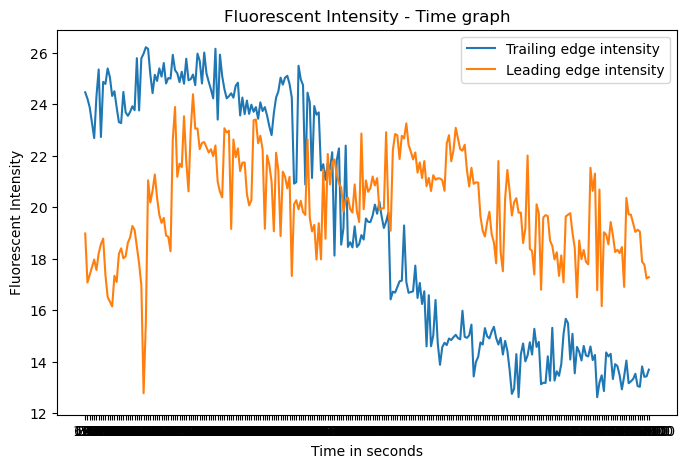

In [41]:
plt.figure(figsize=(8,5))
plt.plot(intensity_dataframe.Time, intensity_dataframe.Trailing, label="Trailing edge intensity")
plt.plot(intensity_dataframe.Time, intensity_dataframe.Leading, label="Leading edge intensity")

plt.title("Fluorescent Intensity - Time graph")
plt.ylabel("Fluorescent Intensity")
plt.xlabel("Time in seconds")
plt.legend()
plt.xticks(intensity_dataframe.Time)
plt.show()

- Before light stimulation, SWELL1 localizes primarily at the trailing edge of cells migrating inside confining channels
- Light stimulation at the cell leading edge gradually promotes local SWELL1 enrichment, which is accompanied by a reduction of SWELL1 intensity at the opposite pole

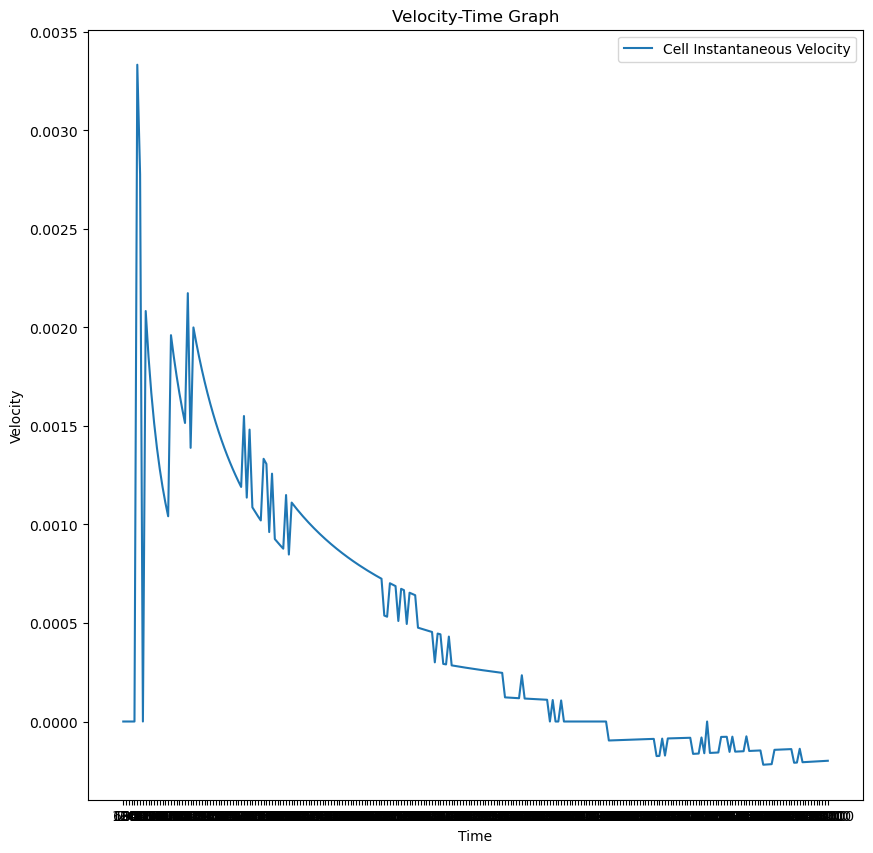

In [44]:
plt.figure(figsize=(10,10))
plt.plot(intensity_dataframe.Time, intensity_dataframe["Average Velocity"], label="Cell Instantaneous Velocity")

plt.title("Velocity-Time Graph")
plt.ylabel("Velocity")
plt.xlabel("Time")
plt.legend()
plt.xticks(intensity_dataframe.Time)
plt.show()

- During this process, cell migration velocity decreases as the front-to-rear ratio of SWELL1 expression progressively increases